# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
data = pd.read_csv("w8a/w8a.csv", sep=";", header=None)

X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.985320989158241

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Write the expression of loss  and gradient for a batch

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

#### ML Implementation that we have seen in the course

In [40]:
import copy

class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.coef_history_ = []
        self.loss_history = []

    def logistic(self, z):
        # logistic function
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y, start=None, lr=1e-1, bsize=50, max_iter=500):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """   
        n_data, n_features = X.shape
        ones_column = np.ones((n_data, 1))
        X_ = np.concatenate((X, ones_column), axis = 1)
        self.coef_ = np.random.random((n_features+1,))
        self.lr_ = lr
        for epoch in range(max_iter):
            epochLoss = []
            for (batchX, batchY) in self.next_batch(X_, y, bsize):
                loss = self.compute_loss(batchX, batchY)
                epochLoss.append(np.sum(loss ** 2))
                grad = self.compute_grad(batchX, batchY)
                self.coef_ -= self.lr_ * grad
            self.loss_history.append(np.average(epochLoss))
        
    def compute_loss(self, X, y):
        '''Compute the logistic loss over all observations'''
        z = - y * (X @ self.coef_.reshape(-1,1))
        loss = np.sum(np.log(1 + np.exp(z))) + (self.alpha_ / 2) * np.linalg.norm(self.coef_)
        return loss
    
    def compute_grad(self, X, y):
        '''Compute a minibatch gradient'''      
        z = - y * self.logistic(- y * (X @ self.coef_.reshape(1, -1).T))
        grad = np.sum(z * X, axis=0) + self.alpha_ * self.coef_
        return grad
    
    @staticmethod
    def next_batch(X, y, batchSize):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, X.shape[0], batchSize):
            # yield a tuple of the current batched data and labels
            yield (X[i:i + batchSize], y[i:i + batchSize])
            
    def predict_proba(self, X):
        n_data, n_features = X.shape
        ones_column = np.ones((n_data, 1))
        X_ = np.concatenate((X, ones_column), axis = 1)
        return self.logistic((X_ @ self.coef_.reshape(-1, 1))).reshape(-1)
    
    def predict(self, X, threshold = 0.5):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (-1 or 1)
        """
        predictions = self.predict_proba(X)
        predictions[predictions >= threshold] = 1
        predictions[predictions < threshold] = -1
        return predictions

In [41]:
model = StochasticLogisticRegression(alpha=2) 
model.fit(X_train, y_train.reshape(-1, 1), bsize=100, max_iter=500)
y_pred = model.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred)

0.9696065294189304

Text(0.5, 1.0, 'Loss function')

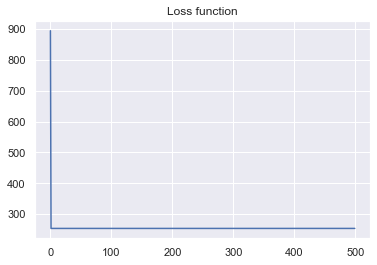

In [44]:
plt.plot(model.loss_history)
plt.title('Loss function')

In [45]:
thresholds = [0.20, 0.30, 0.35,0.40, 0.45, 0.50]
for thresh in thresholds:
    y_pred = model.predict(X_test, thresh)
    print(f'For threshold = {thresh}, the accuracy score is equal to {accuracy_score(y_test, y_pred)}')
    print()
    print('-'*50)

For threshold = 0.2, the accuracy score is equal to 0.8531489828237301

--------------------------------------------------
For threshold = 0.3, the accuracy score is equal to 0.9699719819710074

--------------------------------------------------
For threshold = 0.35, the accuracy score is equal to 0.970154708247046

--------------------------------------------------
For threshold = 0.4, the accuracy score is equal to 0.9696674381776099

--------------------------------------------------
For threshold = 0.45, the accuracy score is equal to 0.9697283469362894

--------------------------------------------------
For threshold = 0.5, the accuracy score is equal to 0.9696065294189304

--------------------------------------------------


I don't know why but it's overfitting, maybe it's the way I compute the mini batch gradient descent ... That's why I tried with the classical implementation of Logistic Regression below

#### Classical ML Implementation
The loss function here is just 
$$L(\textbf{w}) = \sum_{i=1}^n (y_i - logistic(\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

In [46]:
import copy

class StochasticLogisticRegressionV1():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.label_0 = None
        self.label_1 = None
        self.coef_history_ = []
        self.f_history_ = []
        self.loss_history = []

    def logistic(self, z):
        # logistic function
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y, start=None, lr=1e-1, bsize=50, max_iter=500):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """   
        self.coef_ = np.random.uniform(size=(X.shape[1]+1,))
        X = np.c_[np.ones((X.shape[0])), X]
        self.lr_ = lr
        labels = sorted(list(set(list(y))))
        self.label_0 = labels[0]
        self.label_1 = labels[1]
        y_new = copy.deepcopy(y)
        y_new[y_new == self.label_0] = float(0)
        y_new[y_new == self.label_1] = float(1)
        for epoch in range(max_iter):
            epochLoss = []
            for (batchX, batchY) in self.next_batch(X, y_new, bsize):
                loss = self.compute_loss(batchX, batchY)
                epochLoss.append(np.sum(loss ** 2))
                grad = self.compute_grad(batchX, loss)
                self.coef_ -= self.lr_ * grad
            self.loss_history.append(np.average(epochLoss))

        
        def f_lr(beta):
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
        
    def compute_loss(self, X, y):
        '''Compute the logistic loss over all observations'''
        yhat = self.logistic(X @ self.coef_)
        loss = yhat - y
        return loss
    
    def compute_grad(self, X, loss):
        '''Compute a minibatch gradient'''
        N = X.shape[0]
        delta_grad = (1/N) * (((X.T @ loss)) + self.alpha_ * np.sum(self.coef_))
        return delta_grad
    
    @staticmethod
    def next_batch(X, y, batchSize):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, X.shape[0], batchSize):
            # yield a tuple of the current batched data and labels
            yield (X[i:i + batchSize], y[i:i + batchSize])
            
    def predict_proba(self, X):
        return self.logistic((X @ self.coef_[1:]) + self.coef_[0])
    
    def predict(self, X, threshold = 0.5):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (-1 or 1)
        """
        predictions = []
        for x in X:
            if self.predict_proba(x) >= threshold:
                predictions.append(self.label_1)
            else:
                predictions.append(self.label_0)
        return np.array(predictions)

Apply to the data

In [54]:
model = StochasticLogisticRegressionV1(alpha=2) 
model.fit(X_train, y_train, bsize=100)
y_pred = model.predict(X_test)

In [48]:
accuracy_score(y_pred, y_test)

0.984468266536728

Text(0.5, 1.0, 'Loss function')

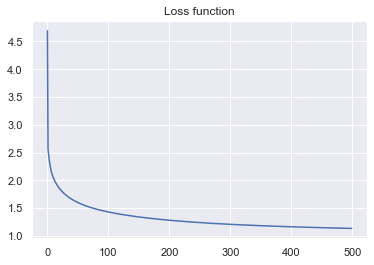

In [49]:
plt.plot(model.loss_history)
plt.title('Loss function')

In [50]:
thresholds = [0.20, 0.30, 0.35,0.40, 0.45, 0.50]
for thresh in thresholds:
    y_pred = model.predict(X_test, thresh)
    print(f'For threshold = {thresh}, the accuracy score is equal to {accuracy_score(y_test, y_pred)}')
    print()
    print('-'*50)

For threshold = 0.2, the accuracy score is equal to 0.9833110001218175

--------------------------------------------------
For threshold = 0.3, the accuracy score is equal to 0.9840419052259715

--------------------------------------------------
For threshold = 0.35, the accuracy score is equal to 0.9848946278474845

--------------------------------------------------
For threshold = 0.4, the accuracy score is equal to 0.9846509928127665

--------------------------------------------------
For threshold = 0.45, the accuracy score is equal to 0.984468266536728

--------------------------------------------------
For threshold = 0.5, the accuracy score is equal to 0.984468266536728

--------------------------------------------------


Implement only one acceleration method and compare the results

In [51]:
class Adam():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, lr=1e-3, gamma=0.9, beta=0.999, max_iter=100,
                 lambd=0., batch_size=1, eps=1e-10, debias=True):
        self.lamda_ = lambd
        self.lr_ = lr
        self.batch_size_ = batch_size
        self.first_moment_history_ = None
        self.second_moment_history_ = None
        self.gamma_ = gamma
        self.beta_ = beta
        self.eps_ = eps
        self.coef_ = None
        self.debias_ = debias
        self.label_0 = None
        self.label_1 = None
        self.loss_history = []

    def logistic(self, z):
        # logistic function
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y, start=None, lr=1e-1, bsize=50, max_iter=500):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """   
        self.coef_ = np.random.uniform(size=(X.shape[1]+1,))
        self.first_moment_history = np.zeros(X.shape[1]+1)
        self.second_moment_history = np.zeros(X.shape[1]+1)
        X = np.c_[np.ones((X.shape[0])), X]
        self.lr_ = lr
        labels = sorted(list(set(list(y))))
        self.label_0 = labels[0]
        self.label_1 = labels[1]
        y_new = copy.deepcopy(y)
        y_new[y_new == self.label_0] = float(0)
        y_new[y_new == self.label_1] = float(1)
        for epoch in range(max_iter):
            epochLoss = []
            for (batchX, batchY) in self.next_batch(X, y_new, bsize):
                loss = self.compute_loss(batchX, batchY)
                epochLoss.append(np.sum(loss ** 2))
                grad = self.compute_grad(batchX, loss)
                first_moment = self.gamma_ * self.first_moment_history + (1-self.gamma_) * grad
                second_moment = self.beta_ * self.second_moment_history + (1-self.beta_) * np.square(grad)
                self.first_moment_history, self.second_moment_history = first_moment, second_moment
                mt = first_moment / (1 - self.gamma_)
                vt = second_moment / (1 - self.beta_)
                self.coef_ -= self.lr_ * ( mt / np.sqrt(vt) + self.eps_)
            self.loss_history.append(np.average(epochLoss))

        
        def f_lr(beta):
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
        
    def compute_loss(self, X, y):
        '''Compute the logistic loss over all observations'''
        yhat = self.logistic(X @ self.coef_)
        loss = yhat - y
        return loss
    
    def compute_grad(self, X, loss):
        '''Compute a minibatch gradient'''
        N = X.shape[0]
        delta_grad = (1/N) * (((X.T @ loss)) + self.lamda_ * np.sum(self.coef_))
        return delta_grad
    
    @staticmethod
    def next_batch(X, y, batchSize):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, X.shape[0], batchSize):
            # yield a tuple of the current batched data and labels
            yield (X[i:i + batchSize], y[i:i + batchSize])
            
    def predict_proba(self, X):
        return self.logistic((X @ self.coef_[1:]) + self.coef_[0])
    
    def predict(self, X, threshold = 0.5):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (-1 or 1)
        """
        predictions = []
        for x in X:
            if self.predict_proba(x) >= threshold:
                predictions.append(self.label_1)
            else:
                predictions.append(self.label_0)
        return np.array(predictions)

In [55]:
model_speedup = Adam(lambd=2)
model_speedup.fit(X_train, y_train, bsize=100)
y_pred = model_speedup.predict(X_test)

In [56]:
accuracy_score(y_pred, y_test)

0.986295529297113

Text(0.5, 1.0, 'Comparision between Normal and Adam')

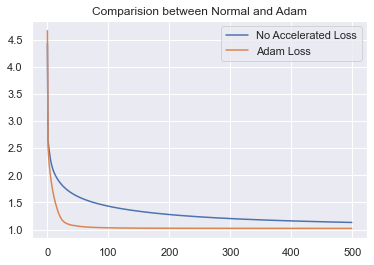

In [57]:
a, = plt.plot(model.loss_history)
b, = plt.plot(model_speedup.loss_history)
plt.legend((a, b), ('No Accelerated Loss', 'Adam Loss'))
plt.title('Comparision between Normal and Adam')

As we can see, the model with Adam converges faster to the minimum that the normal one

In [58]:
thresholds = [0.20, 0.30, 0.35,0.40, 0.45, 0.50]
for thresh in thresholds:
    y_pred = model_speedup.predict(X_test, thresh)
    print(f'For threshold = {thresh}, the accuracy score is equal to {accuracy_score(y_test, y_pred)}')
    print()
    print('-'*50)

For threshold = 0.2, the accuracy score is equal to 0.983615543915215

--------------------------------------------------
For threshold = 0.3, the accuracy score is equal to 0.9859909855037154

--------------------------------------------------
For threshold = 0.35, the accuracy score is equal to 0.9859909855037154

--------------------------------------------------
For threshold = 0.4, the accuracy score is equal to 0.9863564380557924

--------------------------------------------------
For threshold = 0.45, the accuracy score is equal to 0.9864173468144719

--------------------------------------------------
For threshold = 0.5, the accuracy score is equal to 0.986295529297113

--------------------------------------------------


Our best accuracy was 0.9864 which is better than the sklearn implementation !

Ressources :
https://www.pyimagesearch.com/2016/10/17/stochastic-gradient-descent-sgd-with-python/


https://towardsdatascience.com/logistic-regression-using-gradient-descent-optimizer-in-python-485148bd3ff2